In [ ]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Dense , Dropout, Input
from keras.optimizers import Adam

import random

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preprocessing


In [ ]:
WMH=np.load("/content/drive/MyDrive/Uni/Sandy_Jiang_503726/WMH_masks.npy")
skew=np.load("/content/drive/MyDrive/Uni/Sandy_Jiang_503726/skew_dataset.npy")
mean=np.load("/content/drive/MyDrive/Uni/Sandy_Jiang_503726/mean_dataset.npy")
std=np.load("/content/drive/MyDrive/Uni/Sandy_Jiang_503726/std_dataset.npy")
kurtosis=np.load("/content/drive/MyDrive/Uni/Sandy_Jiang_503726/kurtosis_dataset.npy")
flair=np.load("/content/drive/MyDrive/Uni/Sandy_Jiang_503726/FLAIR_dataset.npy")

In [ ]:
#Concatenating numpy arrays in a pandas dataframe
df = pd.DataFrame({
  "WMH": WMH.flatten(),
  "skew": skew.flatten(),
  "mean": mean.flatten(),
  "std": std.flatten(),
  "kurtosis": kurtosis.flatten(),
})
df

,WMH,skew,mean,std,kurtosis
0,0.0,-5.0,-2.571483,0.0,-5.0
1,0.0,-5.0,-2.709622,0.0,-5.0
2,0.0,-5.0,-2.246221,0.0,-5.0
3,0.0,-5.0,-2.524610,0.0,-5.0
4,0.0,-5.0,-2.375648,0.0,-5.0
...,...,...,...,...,...
17160541,0.0,-5.0,-2.457421,0.0,-5.0
17160542,0.0,-5.0,-2.419266,0.0,-5.0
17160543,0.0,-5.0,-2.146197,0.0,-5.0
17160544,0.0,-5.0,-2.147632,0.0,-5.0


In [ ]:
df.describe()

,WMH,skew,mean,std,kurtosis
count,1.716055e+07,1.716055e+07,1.716055e+07,1.716055e+07,1.716055e+07
mean,8.690749e-03,-1.081903e+00,3.862075e+04,5.352159e+03,-1.128514e+00
std,9.281821e-02,2.336422e+00,2.287832e+05,4.057623e+04,2.786512e+00
min,0.000000e+00,-5.000000e+00,-3.254506e+00,0.000000e+00,-5.000000e+00
25%,0.000000e+00,-1.804565e+00,-1.380615e+00,1.383028e+00,-1.543146e+00
50%,0.000000e+00,-2.426866e-01,9.446399e+01,7.852620e+00,-8.623440e-01
75%,0.000000e+00,4.104616e-01,1.509008e+02,2.657566e+01,-8.482275e-02
max,1.000000e+00,3.614784e+00,4.427211e+06,1.711891e+06,1.106667e+01


In [ ]:
df.isnull().sum(axis=0)

,0
WMH,0
skew,0
mean,0
std,0
kurtosis,0


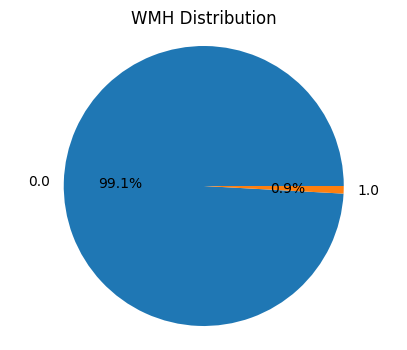

In [ ]:
#target plot
WMH_counts = df['WMH'].value_counts()

plt.figure(figsize=(5, 4))
plt.pie(WMH_counts, labels=WMH_counts.index, autopct='%1.1f%%',)
plt.title('WMH Distribution')
plt.axis('equal')

plt.show()

Scaling the data with a min max scaler allows the data to be scaled in 0 to 1 range

In [ ]:
#Scaling the features
transformation=ColumnTransformer(transformers=[
        ('min_max', MinMaxScaler(),['skew', 'mean', 'std', 'kurtosis'] )
    ],
    verbose_feature_names_out=False,
    remainder='passthrough',
)

scaled_data = transformation.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=transformation.get_feature_names_out())
scaled_df

,skew,mean,std,kurtosis,WMH
0,0.0,1.542783e-07,0.0,0.0,0.0
1,0.0,1.230760e-07,0.0,0.0,0.0
2,0.0,2.277471e-07,0.0,0.0,0.0
3,0.0,1.648659e-07,0.0,0.0,0.0
4,0.0,1.985127e-07,0.0,0.0,0.0
...,...,...,...,...,...
17160541,0.0,1.800423e-07,0.0,0.0,0.0
17160542,0.0,1.886605e-07,0.0,0.0,0.0
17160543,0.0,2.503401e-07,0.0,0.0,0.0
17160544,0.0,2.500160e-07,0.0,0.0,0.0


Taking a look at the effective range of the features:

In [ ]:
scaled_df['skew'].min(), scaled_df['skew'].max()

(0.0, 1.0)

In [ ]:
scaled_df['mean'].min(), scaled_df['mean'].max()

(0.0, 1.0)

In [ ]:
scaled_df['std'].min(), scaled_df['std'].max()

(0.0, 0.9999999999999999)

In [ ]:
scaled_df['kurtosis'].min(), scaled_df['kurtosis'].max()

(0.0, 0.9999999999999999)

In [ ]:
#dividing target from feature
X = scaled_df.drop(['WMH'], axis=1)
Y = scaled_df['WMH']

I perform undersampling to ensure data balance and check if the data was effectively balanced

In [ ]:
#Undersampling
from imblearn.under_sampling import NearMiss
from collections import Counter

nm = NearMiss(version=1)
X_resampled, y_resampled = nm.fit_resample(X, Y)

selected_indices = nm.sample_indices_

class_counts = Counter(y_resampled)
print(class_counts)

NameError: name 'X' is not defined

In [ ]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_series = pd.Series(y_resampled)

# WMH classification with neural network


In [ ]:
#Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled_df, y_resampled, test_size=0.3, stratify=y_resampled,  random_state=30, shuffle=True)

In [ ]:
#Get the indices of the test set in the original dataset
test_indices = selected_indices[X_test.index]

print(f"Test indices: {test_indices[:10]}")  # Print first 10 indices for inspection

Test indices: [13702036 11947639 16411807 10297319 11974076 11394360 10764726 10986881
 10874617  7238242]


In [ ]:
#neural network implementation
from keras.regularizers import l2
from keras.initializers import VarianceScaling
import tensorflow as tf

tf.random.set_seed(30)

model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#running the model
opt=Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size = 100, epochs = 30, validation_data=(X_test, y_test))

Epoch 1/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6927 - loss: 0.5594 - val_accuracy: 0.7332 - val_loss: 0.5196
Epoch 2/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7262 - loss: 0.5256 - val_accuracy: 0.7325 - val_loss: 0.5209
Epoch 3/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7280 - loss: 0.5196 - val_accuracy: 0.7439 - val_loss: 0.5084
Epoch 4/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7347 - loss: 0.5159 - val_accuracy: 0.7368 - val_loss: 0.5153
Epoch 5/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7399 - loss: 0.5093 - val_accuracy: 0.7292 - val_loss: 0.5204
Epoch 6/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7414 - loss: 0.5072 - val_accuracy: 0.7276 - val_loss: 0.5175
Epoch 7/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7432 - loss: 0.5042 - val_accuracy: 0.7448 - val_loss: 0.5045
Epoch 8/30
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7448 - loss: 0.5020 - 

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
rm ./untitled_project/tuner0.json

rm: cannot remove './untitled_project/tuner0.json': No such file or directory


I perform hyperparameter tuning to see if i can get a better result, more speciffically I'm tuning the number of layers of the neural network, the number of unit of the dense layers, the dropout rate and the learning rate

In [ ]:
#Performing hyperparameter tuning with Keras tuner
from keras_tuner import RandomSearch
from keras.models import Sequential

def build_model(hp):
  model = Sequential()
  model.add(Input(shape=(X_resampled.shape[1],)))

  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(Dense(hp.Int(f'units_{i}', 16, 128, step=16), activation='relu'))
    model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

  model.add(Dense(1, activation='sigmoid'))

  learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5,)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=64)

Trial 5 Complete [00h 02m 16s]
val_accuracy: 0.7449124455451965

Best val_accuracy So Far: 0.7610831260681152
Total elapsed time: 00h 14m 24s


The normal model's prediction seems to be better then the hypertuned one so I proceed to take only that one into consideration

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

best_model = tuner.hypermodel.build(best_hps)
model.summary()

{'num_layers': 5, 'units_0': 112, 'dropout_0': 0.2, 'learning_rate': 5.6061500005539445e-05, 'units_1': 48, 'dropout_1': 0.2, 'units_2': 96, 'dropout_2': 0.2, 'units_3': 48, 'dropout_3': 0.2, 'units_4': 16, 'dropout_4': 0.1}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,837 (34.52 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,892 (23.02 KB)

In [ ]:
#train the model obteined from the hyperparameter tuning with 30 epochs
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

Epoch 1/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.5629 - loss: 0.6696 - val_accuracy: 0.7025 - val_loss: 0.5583
Epoch 2/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6988 - loss: 0.5629 - val_accuracy: 0.7256 - val_loss: 0.5302
Epoch 3/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7232 - loss: 0.5350 - val_accuracy: 0.7322 - val_loss: 0.5214
Epoch 4/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7305 - loss: 0.5255 - val_accuracy: 0.7356 - val_loss: 0.5143
Epoch 5/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7333 - loss: 0.5194 - val_accuracy: 0.7434 - val_loss: 0.5044
Epoch 6/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7390 - loss: 0.5131 - val_accuracy: 0.7503 - val_loss: 0.5006
Epoch 7/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7431 - loss: 0.5090 - val_accuracy: 0.7552 - val_loss: 0.4971
Epoch 8/30
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7458 - loss: 0

In [ ]:
#Get the prediction
y_pred_prob = best_model.predict(X_test)

threshold = 0.5
y_pred_nn = (y_pred_prob > threshold).astype(int)

2797/2797 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step


In [ ]:
#Printing the performance scores
print(f"accuracy:{accuracy_score(y_test, y_pred_nn)} f1:{f1_score(y_test, y_pred_nn)}, recall:{recall_score(y_test, y_pred_nn)}, precision:{precision_score(y_test, y_pred_nn)}")

accuracy:0.7786171675066772 f1:0.7572065888812629, recall:0.6904251039291941, precision:0.8382903663500678


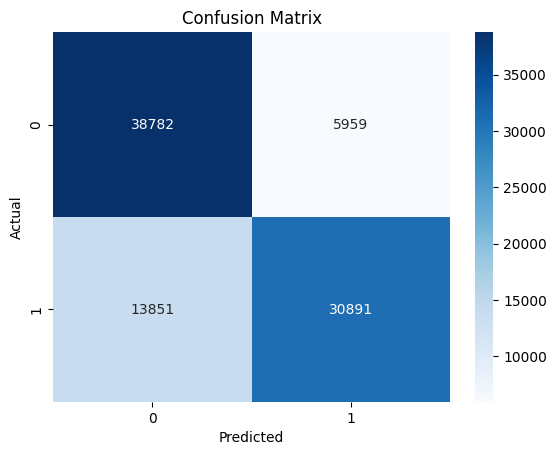

In [ ]:
#Confusino matrix
conf_matrix = confusion_matrix(y_test, y_pred_nn)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Stratified 10 Fold cross evaluation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list, f1_list, recall_list, precision_list = [], [], [], []

for train_index, test_index in skf.split(X_resampled, y_resampled):
  x_train_fold, x_test_fold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
  y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

  model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(x_train_fold, y_train_fold, epochs=5, batch_size=32)

  y_pred_prob = model.predict(x_test_fold)
  y_pred = (y_pred_prob > 0.5).astype(int)

  accuracy_list.append(accuracy_score(y_test_fold, y_pred))
  f1_list.append(f1_score(y_test_fold, y_pred))
  recall_list.append(recall_score(y_test_fold, y_pred))
  precision_list.append(precision_score(y_test_fold, y_pred))

#Print min result, max result, avg result and std
print(f"Min accuracy: {min(accuracy_list)} Max accuracy: {max(accuracy_list)} Average accuracy: {np.mean(accuracy_list):.4f} std: {np.std(accuracy_list):.4f}")
print(f"Min f1: {min(f1_list)} Max f1: {max(f1_list)} Average f1: {np.mean(f1_list):.4f} std: {np.std(f1_list):.4f}")
print(f"Min recall: {min(recall_list)} Max recall: {max(recall_list)} Average recall: {np.mean(recall_list):.4f} std: {np.std(recall_list):.4f}")
print(f"Min precision: {min(precision_list)} Max precision: {max(precision_list)} Average precision: {np.mean(precision_list):.4f} std: {np.std(precision_list):.4f}")


Epoch 1/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7713 - loss: 0.4686
Epoch 2/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7719 - loss: 0.4681
Epoch 3/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.7723 - loss: 0.4661
Epoch 4/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7725 - loss: 0.4651
Epoch 5/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.7741 - loss: 0.4638
933/933 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step
Epoch 1/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7719 - loss: 0.4649
Epoch 2/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7716 - loss: 0.4634
Epoch 3/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.7735 - loss: 0.4625
Epoch 4/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.7733 - loss: 0.4623
Epoch 5/5
8389/8389 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.7739 - loss: 0.4618
933/933 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/5
8389/8389 ━━━━━━━━━━━━━━━━

In [ ]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

(0.2, 1.0)

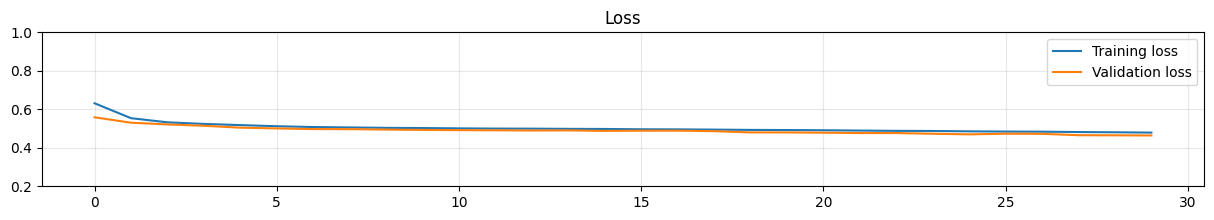

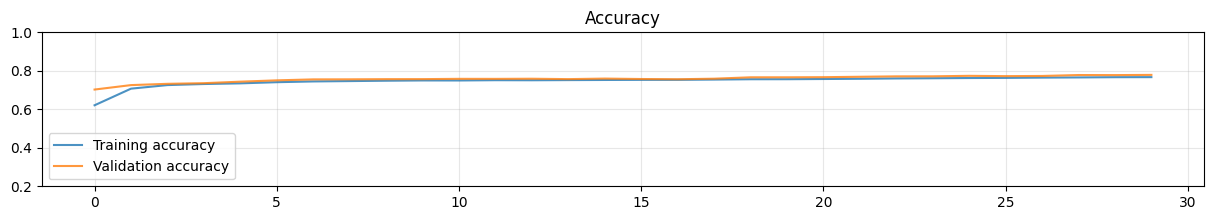

In [ ]:
#Plot of the loss
plt.figure(figsize=(15,2))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.ylim(0.2, 1)

#Plot of the accuracy
plt.figure(figsize=(15,2))
plt.plot(history.history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history.history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.ylim(0.2, 1)

# WMH evalutation with FIS

In [ ]:
np.random.seed(41)
random.seed(41)

#Membership function definition
def membership_mean(x):
  if x < 0.3:
    return max(0, (x - 0.1) / 0.2)
  elif x < 0.7:
    return 1
  else:
    return max(0, (0.9 - x) / 0.2)

def membership_std(x):
  if x < 0.3:
    return max(0, (x - 0.1) / 0.2)
  elif x < 0.7:
    return 1
  else:
    return max(0, (0.9 - x) / 0.2)

def membership_skew(x):
  if x < 0.3:
    return max(0, (x - 0.1) / 0.2)
  elif x < 0.7:
    return 1
  else:
    return max(0, (0.9 - x) / 0.2)

def membership_kurtosis(x):
  if x < 0.3:
    return max(0, (x - 0.1) / 0.2)
  elif x < 0.7:
    return 1
  else:
    return max(0, (0.9 - x) / 0.2)

In [ ]:
X

,skew,mean,std,kurtosis
0,0.0,1.542783e-07,0.0,0.0
1,0.0,1.230760e-07,0.0,0.0
2,0.0,2.277471e-07,0.0,0.0
3,0.0,1.648659e-07,0.0,0.0
4,0.0,1.985127e-07,0.0,0.0
...,...,...,...,...
17160541,0.0,1.800423e-07,0.0,0.0
17160542,0.0,1.886605e-07,0.0,0.0
17160543,0.0,2.503401e-07,0.0,0.0
17160544,0.0,2.500160e-07,0.0,0.0


In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(membership_mean(X["mean"]), label='Mean')
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1500x500 with 0 Axes>

In [ ]:
#fuzzy rules
def fuzzy_rule_1(skew, kurtosis):  #high skew OR high kurtosis => WMH=Yes
  return max(membership_skew(skew), membership_kurtosis(kurtosis))

def fuzzy_rule_2(mean, std):  #medium mean OR medium std => WMH=Yes
  return max(membership_mean(mean), membership_std(std))

def fuzzy_rule_3(skew, mean):  #low skew AND medium mean => WMH=Yes
  return min(membership_skew(1 - skew), membership_mean(mean))

def fuzzy_rule_4(std, kurtosis):  #high std OR high kurtosis => WMH=Yes
  return max(membership_std(std), membership_kurtosis(kurtosis))

def fuzzy_rule_5(skew, mean, std):  #low skew AND medium mean AND high std => WMH=Yes
  return min(membership_skew(1 - skew), membership_mean(mean), membership_std(std))

def fuzzy_rule_6(mean, kurtosis):  #medium mean AND low kurtosis => WMH=Yes
  return min(membership_mean(mean), membership_kurtosis(1 - kurtosis))

def fuzzy_rule_7(skew, std):  #high skew AND high std => WMH=Yes
  return min(membership_skew(skew), membership_std(std))

def fuzzy_rule_8(mean, kurtosis):  #high mean AND low kurtosis => WMH=Yes
  return min(membership_mean(mean), membership_kurtosis(1 - kurtosis))

def fuzzy_rule_9(skew, mean, kurtosis):  #low skew AND high mean AND high kurtosis => WMH=Yes
  return min(membership_skew(1 - skew), membership_mean(mean), membership_kurtosis(kurtosis))

def fuzzy_rule_10(std, kurtosis):  #low std AND low kurtosis => WMH=Yes
  return min(membership_std(1 - std), membership_kurtosis(1 - kurtosis))

def fuzzy_rule_11(mean, std):  #high mean AND low std => WMH=No
  return min(membership_mean(mean), membership_std(1 - std))

def fuzzy_rule_12(skew, kurtosis):  #low skew AND low kurtosis => WMH=No
  return min(membership_skew(1 - skew), membership_kurtosis(1 - kurtosis))

In [ ]:
#fuzzy inference system definition
def fuzzy_inference_system(X, weights, feature_mask):
  results = np.zeros(len(X))
  for i, row in enumerate(X):
    masked_row = row * feature_mask
    skew, mean, std, kurtosis = masked_row

    rules = np.array([
      fuzzy_rule_1(skew, kurtosis) * weights[0],
      fuzzy_rule_2(mean, std) * weights[1],
      fuzzy_rule_3(skew, mean) * weights[2],
      fuzzy_rule_4(std, kurtosis) * weights[3],
      fuzzy_rule_5(skew, mean, std) * weights[4],
      fuzzy_rule_6(mean, kurtosis) * weights[5],
      fuzzy_rule_7(skew, std) * weights[6],
      fuzzy_rule_8(mean, kurtosis) * weights[7],
      fuzzy_rule_9(skew, mean, kurtosis) * weights[8],
      fuzzy_rule_10(std, kurtosis) * weights[9],
      fuzzy_rule_11(mean, std) * weights[10],
      fuzzy_rule_12(skew, kurtosis) * weights[11]
    ])
    results[i] = max(rules)
  return results

In [ ]:
def initialize_population(size, num_rules, num_features):
  rule_weights = np.random.rand(size, num_rules)
  feature_mask = np.random.randint(2, size=(size, num_features))
  return np.hstack((rule_weights, feature_mask))

def evaluate_population(population, X_train, y_train, num_rules):
  scores = []
  for ind in population:
    rule_weights = ind[:num_rules]
    feature_mask = ind[num_rules:]
    y_pred = fuzzy_inference_system(X_train, rule_weights, feature_mask)
    mse = mean_squared_error(y_train, y_pred)
    scores.append(-mse)
  return np.array(scores)

def tournament_selection(population, scores, k=3):
  selected = []
  for _ in range(len(population) // 2):
    contenders_idx = np.random.choice(len(population), k, replace=False)
    best_idx = contenders_idx[np.argmax(scores[contenders_idx])]
    selected.append(population[best_idx])
  return np.array(selected)

def crossover(parent1, parent2):
  point = random.randint(1, len(parent1) - 1)
  child1 = np.concatenate((parent1[:point], parent2[point:]))
  child2 = np.concatenate((parent2[:point], parent1[point:]))
  return child1, child2

def mutate(individual, mutation_rate=0.2):
  mutation_mask = np.random.rand(len(individual)) < mutation_rate
  individual[mutation_mask] = np.random.rand(np.sum(mutation_mask))
  return individual

In [ ]:
pop_size = 20
generations = 10
mutation_rate = 0.2
num_rules = 12

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

num_features = X_train.shape[1]
population = initialize_population(pop_size, num_rules, num_features)

best_mse = float('inf')
best_individual = None

# Genetic Algorithm Loop
for gen in range(generations):
  scores = evaluate_population(population, X_train, y_train, num_rules)
  best_mse = min(best_mse, -np.max(scores))

  #increase mutation rate if stuck
  if gen % 3 == 0:
    mutation_rate = min(0.5, mutation_rate + 0.05)

  selected = tournament_selection(population, scores)

  #new generation
  next_gen = selected.copy()
  while len(next_gen) < pop_size:
    p1, p2 = selected[np.random.choice(len(selected), 2, replace=False)]
    child1, child2 = crossover(p1, p2)
    child1 = mutate(child1, mutation_rate)
    child2 = mutate(child2, mutation_rate)
    next_gen = np.vstack([next_gen, child1, child2])[:pop_size]

  population = next_gen

  print(f"Generation {gen+1} - Best MSE: {best_mse:.4f}")

Generation 1 - Best MSE: 0.2339
Generation 2 - Best MSE: 0.2339
Generation 3 - Best MSE: 0.2339
Generation 4 - Best MSE: 0.2339
Generation 5 - Best MSE: 0.2339
Generation 6 - Best MSE: 0.2334
Generation 7 - Best MSE: 0.2334
Generation 8 - Best MSE: 0.2212
Generation 9 - Best MSE: 0.2212
Generation 10 - Best MSE: 0.2212


In [ ]:
#FIS results
best_individual = population[np.argmax(scores)]
best_rule_weights = best_individual[:num_rules]
best_feature_mask = best_individual[num_rules:]

print("Best rule weights:", best_rule_weights)
print("Best feature mask:", best_feature_mask)

y_pred = fuzzy_inference_system(X_test, best_rule_weights, best_feature_mask)
y_pred_fis = (y_pred > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred_fis):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_fis):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_fis):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_fis):.4f}")

Best rule weights: [0.03261043 0.51125071 0.64812038 0.99423575 0.52658777 0.90939029
 0.43492332 0.28945736 0.48368196 0.89091245 0.60201692 0.41192255]
Best feature mask: [0. 1. 1. 1.]
Accuracy: 0.7011
F1 Score: 0.6739
Recall: 0.6175
Precision: 0.7415


# Visualisation and comparison of the results


In [ ]:
#mapping the test set predictions to the original dataset for comparison
original_predictions_fis = np.zeros(len(X), dtype=int)
original_predictions_nn = np.zeros(len(X), dtype=int)

original_predictions_fis[test_indices] = y_pred_fis
original_predictions_nn[test_indices] = y_pred_nn.flatten()

original_predictions_fis = original_predictions_fis.reshape(WMH.shape)
original_predictions_nn = original_predictions_nn.reshape(WMH.shape)

In [ ]:
def calculate_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  tpr = tp / (tp + fn)  #True Positive Rate
  tnr = tn / (tn + fp)  #True Negative Rate
  fpr = fp / (fp + tn)  #False Positive Rate
  fnr = fn / (fn + tp)  #False Negative Rate
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  return {
    "TPR": tpr,
    "TNR": tnr,
    "FPR": fpr,
    "FNR": fnr,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
  }

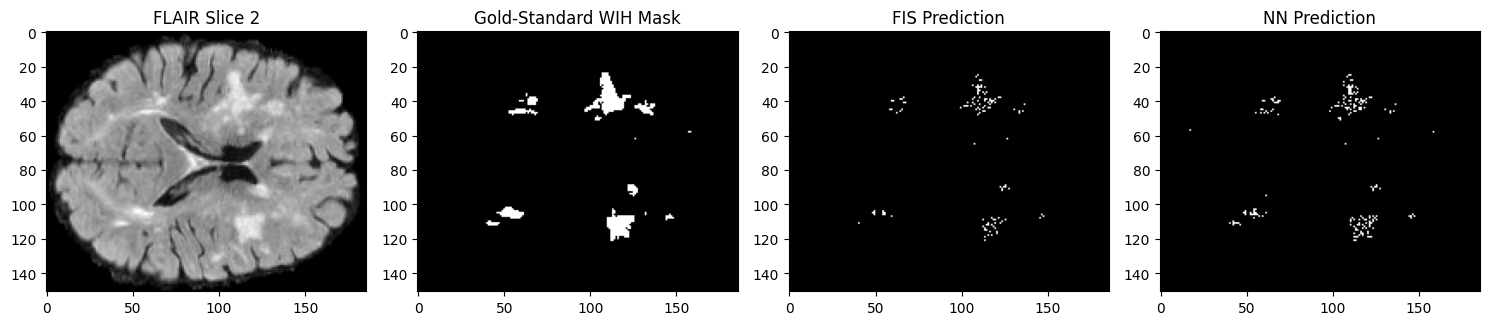

FIS Metrics:
TPR: 0.1804
TNR: 1.0000
FPR: 0.0000
FNR: 0.8196
Accuracy: 0.9801
Precision: 0.9919
Recall: 0.1804
F1 Score: 0.3052

NN Metrics:
TPR: 0.2889
TNR: 0.9999
FPR: 0.0001
FNR: 0.7111
Accuracy: 0.9826
Precision: 0.9850
Recall: 0.2889
F1 Score: 0.4467


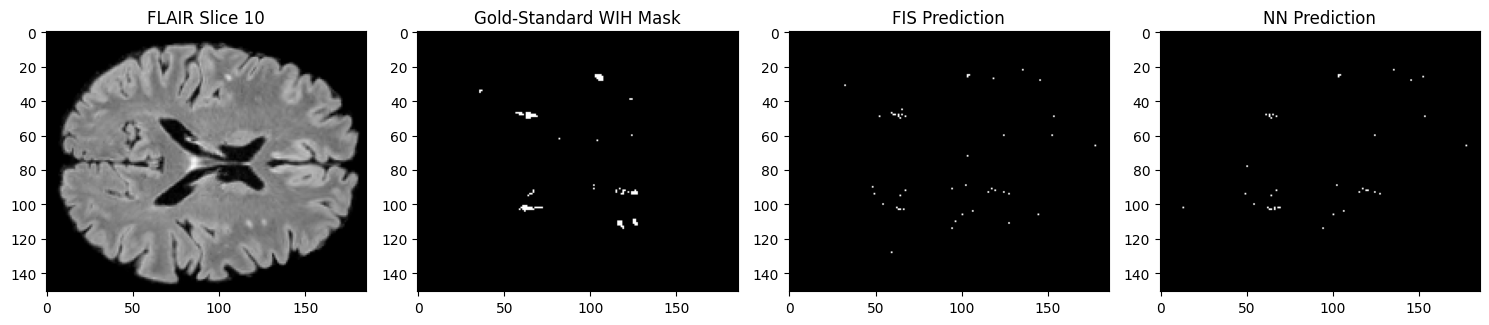

FIS Metrics:
TPR: 0.2083
TNR: 0.9993
FPR: 0.0007
FNR: 0.7917
Accuracy: 0.9959
Precision: 0.5556
Recall: 0.2083
F1 Score: 0.3030

NN Metrics:
TPR: 0.2167
TNR: 0.9996
FPR: 0.0004
FNR: 0.7833
Accuracy: 0.9962
Precision: 0.6842
Recall: 0.2167
F1 Score: 0.3291


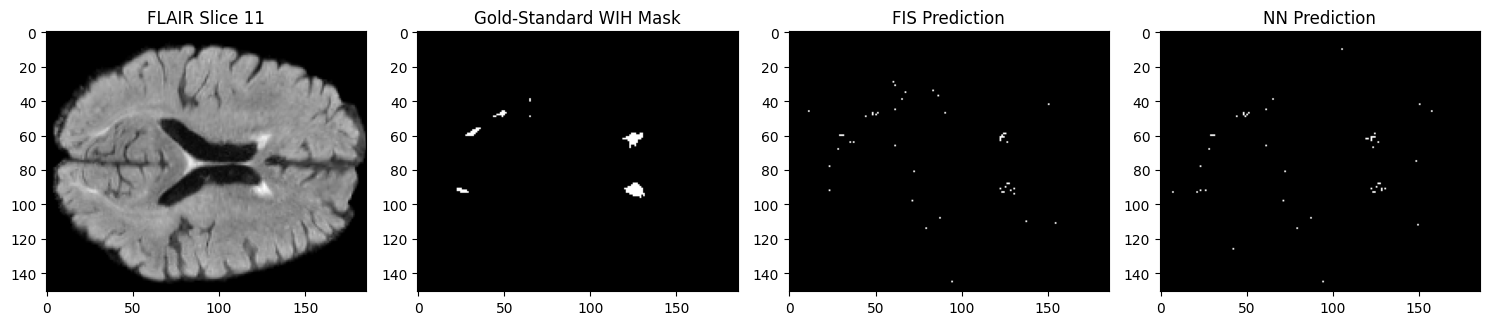

FIS Metrics:
TPR: 0.1677
TNR: 0.9992
FPR: 0.0008
FNR: 0.8323
Accuracy: 0.9943
Precision: 0.5714
Recall: 0.1677
F1 Score: 0.2593

NN Metrics:
TPR: 0.1856
TNR: 0.9994
FPR: 0.0006
FNR: 0.8144
Accuracy: 0.9946
Precision: 0.6458
Recall: 0.1856
F1 Score: 0.2884


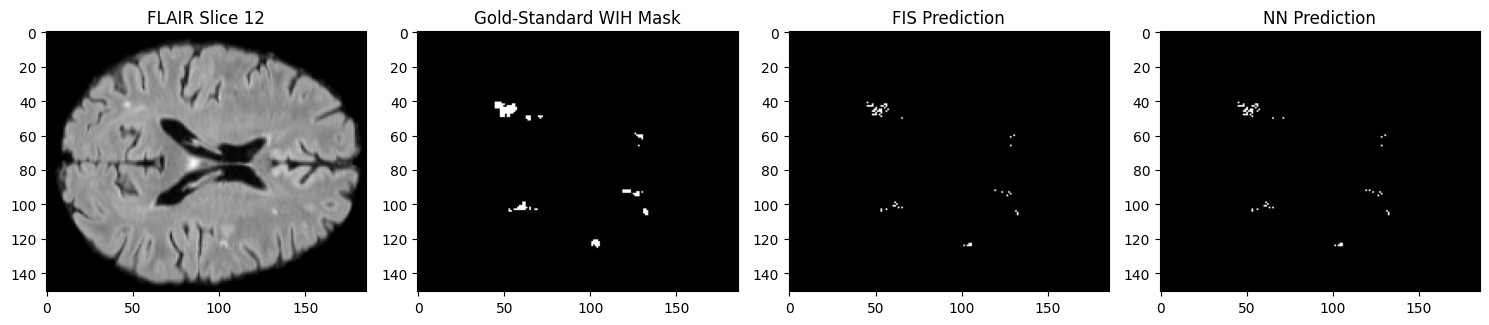

FIS Metrics:
TPR: 0.3412
TNR: 1.0000
FPR: 0.0000
FNR: 0.6588
Accuracy: 0.9960
Precision: 1.0000
Recall: 0.3412
F1 Score: 0.5088

NN Metrics:
TPR: 0.3529
TNR: 1.0000
FPR: 0.0000
FNR: 0.6471
Accuracy: 0.9961
Precision: 1.0000
Recall: 0.3529
F1 Score: 0.5217


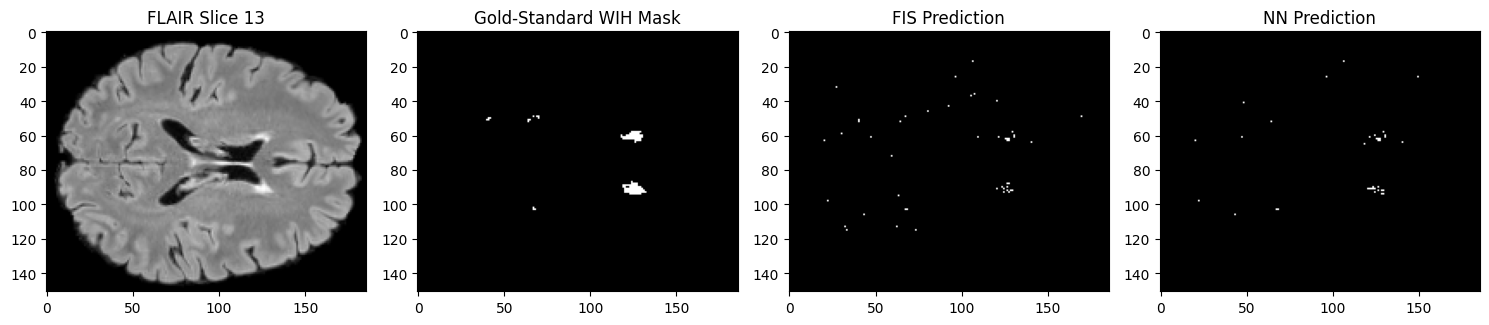

FIS Metrics:
TPR: 0.1894
TNR: 0.9992
FPR: 0.0008
FNR: 0.8106
Accuracy: 0.9954
Precision: 0.5208
Recall: 0.1894
F1 Score: 0.2778

NN Metrics:
TPR: 0.1970
TNR: 0.9996
FPR: 0.0004
FNR: 0.8030
Accuracy: 0.9959
Precision: 0.7222
Recall: 0.1970
F1 Score: 0.3095


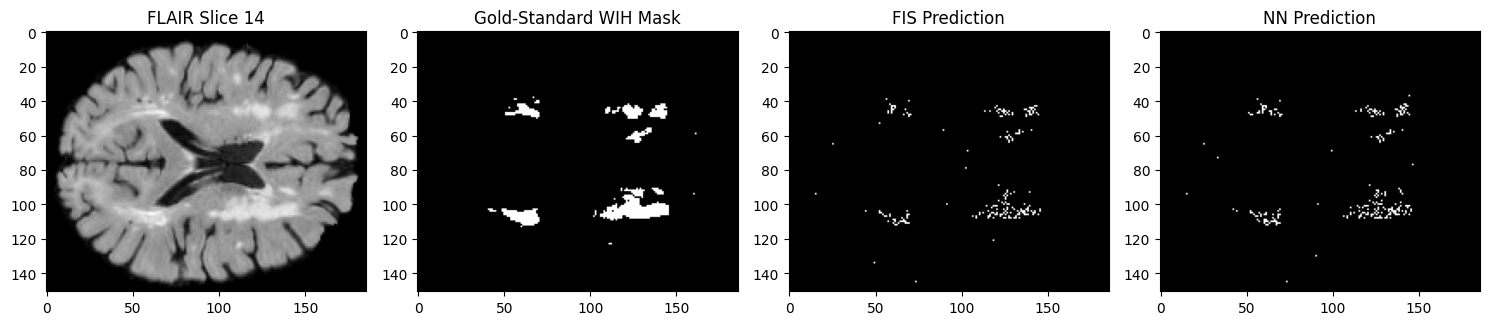

FIS Metrics:
TPR: 0.2348
TNR: 0.9996
FPR: 0.0004
FNR: 0.7652
Accuracy: 0.9767
Precision: 0.9426
Recall: 0.2348
F1 Score: 0.3760

NN Metrics:
TPR: 0.2825
TNR: 0.9996
FPR: 0.0004
FNR: 0.7175
Accuracy: 0.9782
Precision: 0.9556
Recall: 0.2825
F1 Score: 0.4361


In [ ]:
def visualize_subject(subject_id, flair_dataset, wmh_masks, fis_predictions, nn_predictions):

  flair_slice = flair_dataset[:, :, subject_id]
  wmh_mask_slice = wmh_masks[:, :, subject_id]
  fis_pred_slice = fis_predictions[:, :, subject_id]
  nn_pred_slice = nn_predictions[:, :, subject_id]

  wmh_mask_flat = wmh_mask_slice.flatten()
  fis_pred_flat = fis_pred_slice.flatten()
  nn_pred_flat = nn_pred_slice.flatten()

  #Calculate metrics for FIS and NN predictions
  fis_metrics = calculate_metrics(wmh_mask_flat, fis_pred_flat)
  nn_metrics = calculate_metrics(wmh_mask_flat, nn_pred_flat)

  #Plot the slices
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 4, 1)
  plt.imshow(flair_slice, cmap='gray')
  plt.title(f"FLAIR Slice {subject_id}")

  plt.subplot(1, 4, 2)
  plt.imshow(wmh_mask_slice, cmap='gray')
  plt.title("Gold-Standard WIH Mask")

  plt.subplot(1, 4, 3)
  plt.imshow(fis_pred_slice, cmap='gray')
  plt.title("FIS Prediction")

  plt.subplot(1, 4, 4)
  plt.imshow(nn_pred_slice, cmap='gray')
  plt.title("NN Prediction")

  plt.tight_layout()
  plt.show()

  print("FIS Metrics:")
  for key, value in fis_metrics.items():
    print(f"{key}: {value:.4f}")

  print("\nNN Metrics:")
  for key, value in nn_metrics.items():
    print(f"{key}: {value:.4f}")

visualize_subject(2, flair, WMH, original_predictions_fis, original_predictions_nn)
for i in range (10, 15):
  visualize_subject(i, flair, WMH, original_predictions_fis, original_predictions_nn)